In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress


In [16]:
dados = {
    'Peso(g)': [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574,2.1205,2.1665,2.1265,2.1473,2.2201,2.2574],
    'Peso com líquido(g)': [2.2777,2.3243,2.2841,2.6414,2.7172,2.7563,2.9662,3.0104,2.9646,3.1601,3.2253,3.2664],
    'Passos':[50,50,50,150,150,150,250,250,250,300,300,300]
}

df = pd.DataFrame(dados)

In [17]:
df['Peso água(g)']=df['Peso com líquido(g)']-df['Peso(g)']

In [ ]:
passos = df['Passos']
peso_agua =df['Peso água(g)']

y = 3.44921x + -13.78879 (μL)
R² = 0.99997


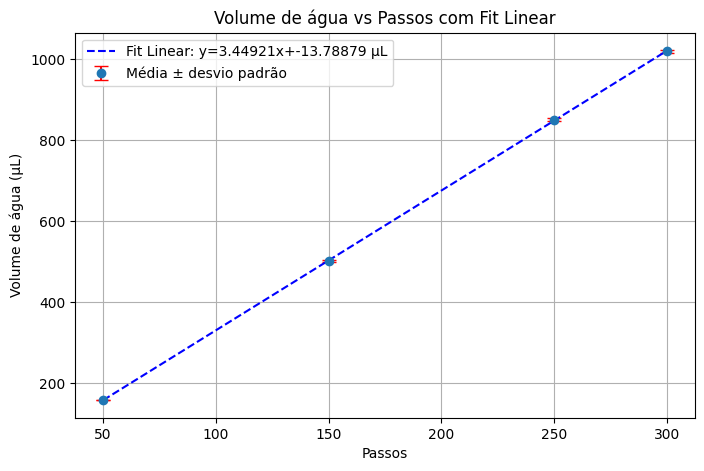

In [21]:

# Densidade da água a 27°C e 1026 mbar
densidade_agua = 0.98975  # g/mL
volume_agua = (peso_agua / densidade_agua) * 1000  # μL

# Média e desvio padrão por passo
passos_unicos = np.unique(passos)
volumes_media = np.array([np.mean(volume_agua[passos == p]) for p in passos_unicos])
volumes_std = np.array([np.std(volume_agua[passos == p]) for p in passos_unicos])

# Fit linear
slope, intercept, r_value, p_value, std_err = linregress(passos_unicos, volumes_media)
print(f"y = {slope:.5f}x + {intercept:.5f} (μL)")
print(f"R² = {r_value**2:.5f}")

# Valores ajustados
volumes_fit = slope * passos_unicos + intercept

# Plot
plt.figure(figsize=(8,5))
plt.errorbar(passos_unicos, volumes_media, yerr=volumes_std, fmt='o', capsize=5, ecolor='red', label='Média ± desvio padrão')
plt.plot(passos_unicos, volumes_fit, 'b--', label=f'Fit Linear: y={slope:.5f}x+{intercept:.5f} μL')
plt.xlabel("Passos")
plt.ylabel("Volume de água (μL)")
plt.title("Volume de água vs Passos com Fit Linear")
plt.legend()
plt.grid(True)
plt.show()

y = 3.39094x (μL/passos)


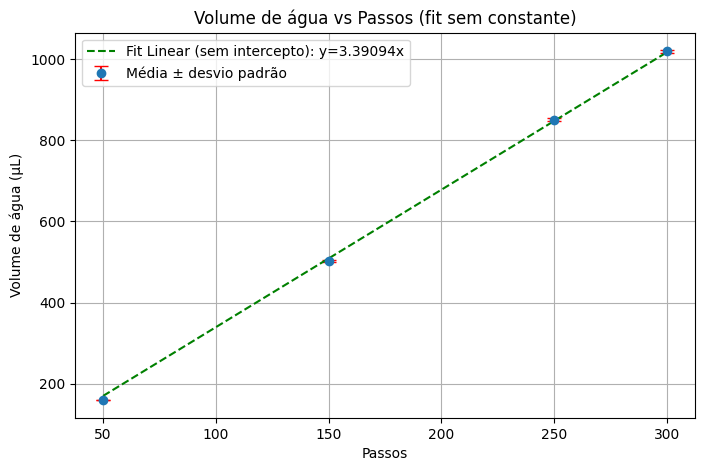

In [23]:


# Densidade da água corrigida
densidade_agua = 0.98975  # g/mL
volume_agua = (peso_agua / densidade_agua) * 1000  # μL

# Média e desvio padrão por passo
passos_unicos = np.unique(passos)
volumes_media = np.array([np.mean(volume_agua[passos == p]) for p in passos_unicos])
volumes_std = np.array([np.std(volume_agua[passos == p]) for p in passos_unicos])

# Fit linear sem constante (reta passando pela origem)
slope_no_intercept = np.sum(passos_unicos * volumes_media) / np.sum(passos_unicos**2)
print(f"y = {slope_no_intercept:.5f}x (μL/passos)")

# Valores ajustados
volumes_fit_no_intercept = slope_no_intercept * passos_unicos

# Plot
plt.figure(figsize=(8,5))
plt.errorbar(passos_unicos, volumes_media, yerr=volumes_std, fmt='o', capsize=5, 
             ecolor='red', label='Média ± desvio padrão')
plt.plot(passos_unicos, volumes_fit_no_intercept, 'g--', 
         label=f'Fit Linear (sem intercepto): y={slope_no_intercept:.5f}x')
plt.xlabel("Passos")
plt.ylabel("Volume de água (μL)")
plt.title("Volume de água vs Passos (fit sem constante)")
plt.legend()
plt.grid(True)
plt.show()
